# Baseline network

This notebook trains the baseline network with exact same architecture as the one in paper [Recognition of handwritten Latin characters with diacritics using CNN](https://journals.pan.pl/dlibra/publication/136210/edition/119099/content/bulletin-of-the-polish-academy-of-sciences-technical-sciences-recognition-of-handwritten-latin-characters-with-diacritics-using-cnn-lukasik-edyta-charytanowicz-malgorzata-milosz-marek-tokovarov-michail-kaczorowska-monika-czerwinski-dariusz-zientarski-tomasz-2021-69-no-1?language=en)

Model architecture description:

"The architecture of the concrete CNN is shown in Fig. 2.
The input is a 32x32 binarized matrix. The input is then prop-
agated through 12 adaptable layers. First come two convolu-
tional layers having 32 filters with the size of 3x3 and stride 1.
Secondly, the output of the convolutional layer is fed to the
ReLU function. The output is down-sampled using a max-pool-
ing operation with a 2x2 stride. Next, the dropout technique is
used with the coefficient 0.25. The four operations (two con-
volutions, nonlinearity, max-pooling, and dropout) are repeated,
using 64 filters for the convolutional layers. The output of the
last layer is then flattened and fed through a fully connected
layer with 256 neurons and ReLU nonlinearities, dropped out
with the 0.25 coefficient, and a final output layer is fully con-
nected with a Softmax activation function. The Adam optimizer
and the cross-entropy loss function were used in the network. 
The output is a probability distribution over 89 classes."




After training, model is serialized and uploaded to W&B project.

In [1]:
import wandb
import tensorflow as tf
import numpy as np
import pathlib
import shutil
from typing import List

def load_data(run) -> List[tf.data.Dataset]:
    """
    Downloads datasets from a wandb artifact and loads them into a list of tf.data.Datasets.
    """

    artifact_name = f"letters_splits_tfds"
    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = pathlib.Path(
        f"./artifacts/{artifact.name.replace(':', '-')}"
    ).resolve()
    if not artifact_dir.exists():
        artifact_dir = artifact.download()
        artifact_dir = pathlib.Path(artifact_dir).resolve()

    # if tf.__version__ minor is less than 10, use
    # tf.data.experimental.load instead of tf.data.Dataset.load

    if int(tf.__version__.split(".")[1]) < 10:
        load_function = tf.data.experimental.load
    else:
        load_function = tf.data.Dataset.load
    
    output_list = []
    for split in ["train", "test", "val"]:
        ds = load_function(str(artifact_dir / split), compression="GZIP")
        output_list.append(ds)
    
    return output_list

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    labels_iterator= ds.map(lambda x, y: y).as_numpy_iterator()
    labels = np.concatenate(list(labels_iterator))
    return len(np.unique(labels))

def preprocess_dataset(ds: tf.data.Dataset, batch_size: int, cache: bool = True) -> tf.data.Dataset:
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
    ds = ds.unbatch().batch(batch_size)
    if cache:
        ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def calculate_model_size_on_disk(path: str) -> int:
    return pathlib.Path(path).stat().st_size    

def calculate_model_num_parameters(model: tf.keras.Model) -> int:
    return model.count_params()

def calculate_model_flops(summary) -> float:
    # from run.summary get GFLOPs or GFLOPS whichever is available
    if "GFLOPs" in summary:
        return summary.get("GFLOPs")
    elif "GFLOPS" in summary:
        return summary.get("GFLOPS")

2023-01-22 17:10:55.654444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
defaults = dict(
    batch_size=32*4,
    epochs=100,    
    optimizer="adam"
)

In [3]:
MODEL_NAME = "baseline-phcd"
run = wandb.init(project="master-thesis", job_type="training", name=MODEL_NAME, config=defaults,)

# hyperparameters

epochs = wandb.config.epochs
bs = wandb.config.batch_size

wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


In [4]:
ds_train, ds_test, ds_val = load_data(run)

num_classes = get_number_of_classes(ds_val)

print(f"There are {num_classes} classes")
print(f"Training set has {len(ds_train)} batches")
print(f"Test set has {len(ds_test)} batches")
print(f"Validation set has {len(ds_val)} batches")

wandb: Downloading large artifact letters_splits_tfds:latest, 54.88MB. 18 files... 
wandb:   18 of 18 files downloaded.  
Done. 0:0:0.0
2023-01-22 17:11:01.083277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-22 17:11:01.087978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 17:11:01.088320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 17:11:01.088937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 17:11:01.089732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_nod

There are 35 classes
Training set has 5508 batches
Test set has 688 batches
Validation set has 688 batches


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Available devices: ", tf.config.list_physical_devices())


Num GPUs Available:  1
Available devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
ds_train = preprocess_dataset(ds_train, batch_size=bs)
ds_val = preprocess_dataset(ds_val, batch_size=bs)
ds_test = preprocess_dataset(ds_test, batch_size=bs, cache=False)

'''
The architecture of the concrete CNN is shown in Fig. 2.
The input is a 32x32 binarized matrix. 
The input is then propagated through 12 adaptable layers. 
First come two convolutional layers having 32 filters with the size of 3x3 and stride 1.
Secondly, the output of the convolutional layer is fed to the
ReLU function. The output is down-sampled using a max-pool-
ing operation with a 2x2 stride. Next, the dropout technique is
used with the coefficient 0.25. The four operations (two con-
volutions, nonlinearity, max-pooling, and dropout) are repeated,
using 64 filters for the convolutional layers. The output of the
last layer is then flattened and fed through a fully connected
layer with 256 neurons and ReLU nonlinearities, dropped out
with the 0.25 coefficient, and a final output layer is fully con-
nected with a Softmax activation function. The Adam optimizer
and the cross-entropy loss function were used in the network
[24]. The output is a probability distribution over 89 classes.
'''

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
        
        # 2 Convolutional layers with 32 filters, 3x3 size, and stride 1
        tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu'),
        
        # Max-pooling operation with 2x2 stride
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        # Dropout with coefficient 0.25
        tf.keras.layers.Dropout(0.25),
        
        # Repeat above 4 operations using 64 filters
        tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.25),
        
        # Flatten the output and feed through fully connected layer with 256 neurons
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),

        # Dropout with coefficient 0.25
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)




model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"./artifacts/{MODEL_NAME}.h5",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

wandb_callback = wandb.keras.WandbCallback(
    save_model=False,
    compute_flops=True,
)

history = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[wandb_callback, checkpoint_callback],
)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Epoch 1/100


2023-01-22 17:11:02.801868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 17:11:02.801923: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-22 17:11:02.802223: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-22 17:11:02.802804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 17:11:02.803033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 17:11:02.803250: I tensor

1377/1377 [==============================] - 27s 16ms/step - loss: 0.5235 - accuracy: 0.8470 - val_loss: 0.1872 - val_accuracy: 0.9438
Epoch 2/100
1377/1377 [==============================] - 22s 16ms/step - loss: 0.2234 - accuracy: 0.9346 - val_loss: 0.1453 - val_accuracy: 0.9558
Epoch 3/100
1377/1377 [==============================] - 22s 16ms/step - loss: 0.1862 - accuracy: 0.9451 - val_loss: 0.1215 - val_accuracy: 0.9632
Epoch 4/100
1377/1377 [==============================] - 21s 16ms/step - loss: 0.1658 - accuracy: 0.9509 - val_loss: 0.1089 - val_accuracy: 0.9670
Epoch 5/100
1377/1377 [==============================] - 21s 15ms/step - loss: 0.1518 - accuracy: 0.9548 - val_loss: 0.0963 - val_accuracy: 0.9707
Epoch 6/100
1377/1377 [==============================] - 21s 15ms/step - loss: 0.1414 - accuracy: 0.9576 - val_loss: 0.0912 - val_accuracy: 0.9725
Epoch 7/100
1377/1377 [==============================] - 21s 15ms/step - loss: 0.1323 - accuracy: 0.9600 - val_loss: 0.0814 - val_

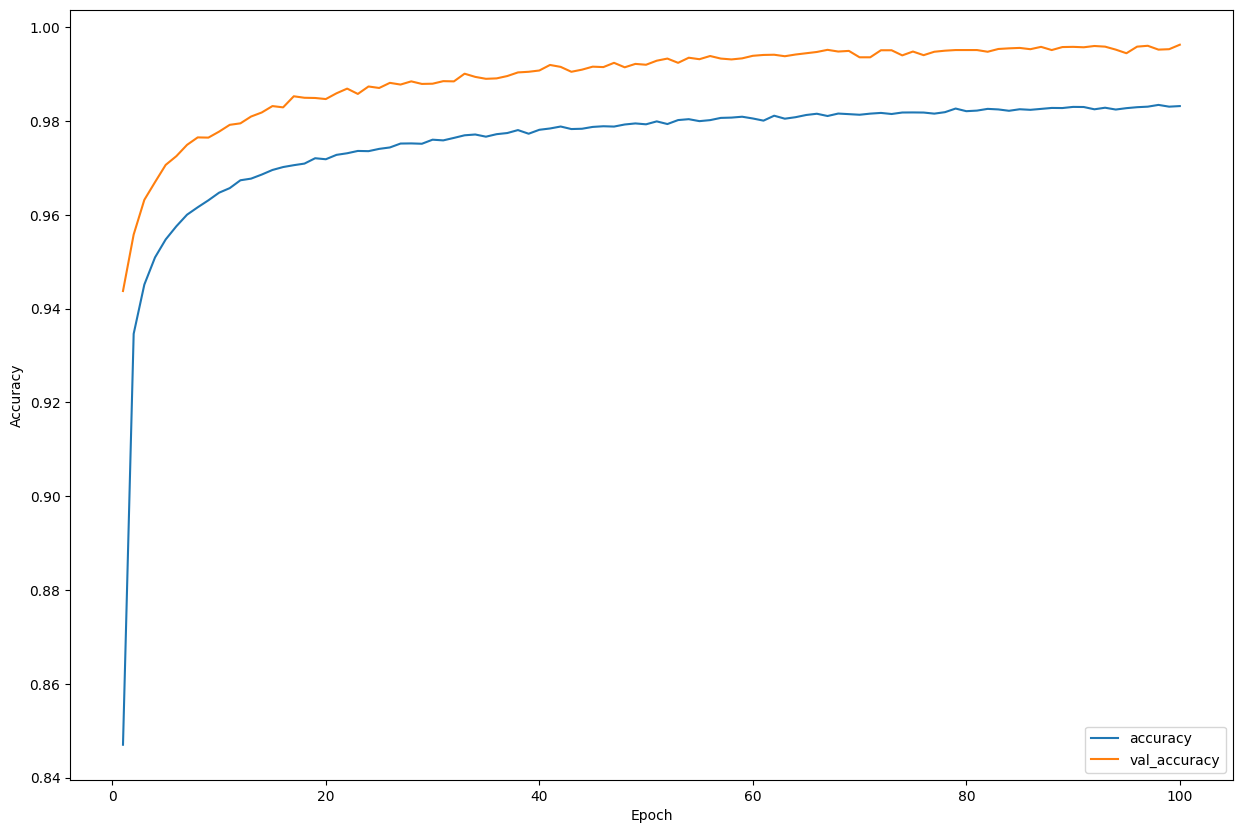

In [7]:
# plot history
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
epochs = range(1, len(history.history["loss"]) + 1)
ax.plot(epochs, history.history["accuracy"], label="accuracy")
ax.plot(epochs, history.history["val_accuracy"], label="val_accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc="lower right")

plt.show()

In [8]:
# calculate model size on disk, flops and number of parameters

flops = wandb.run.summary["GFLOPS"]
disk_size = calculate_model_size_on_disk(f"./artifacts/{MODEL_NAME}.h5")
num_parameters = calculate_model_num_parameters(model)

# evaluate model on ds_test and log to wandb
test_loss, test_acc = model.evaluate(ds_test)

wandb.log({
    "test loss": test_loss, 
    "test accuracy": test_acc, 
    "number of parameters": num_parameters,
    "disk size": disk_size, 
    "model flops": flops
    })


diacritics = {
    62: "ą",
    63: "ć",
    64: "ę",
    65: "ł",
    66: "ń",
    67: "ó",
    68: "ś",
    69: "ź",
    70: "ż",
    71: "Ą",
    72: "Ć",
    73: "Ę",
    74: "Ł",
    75: "Ń",
    76: "Ó",
    77: "Ś",
    78: "Ź",
    79: "Ż"
}

# log test accuracy on these classes separately to wandb

diacritics_acc = {}
for diacritic_label in diacritics.keys():
    ds_test_diacritic = ds_test.filter(lambda x, y: tf.bool(tf.equal(y, diacritic_label)))
    test_loss, test_acc = model.evaluate(ds_test_diacritic)
    diacritics_acc[diacritic_label] = {
        "loss": test_loss,
        "accuracy": test_acc,
        "label": diacritics[diacritic_label],
    }

wandb.log(diacritics_acc)

KeyError: 'GFLOPS'

In [ ]:
# save artifact to wandb
artifact = wandb.Artifact(
    name=MODEL_NAME,
    type="model"
)

# save best model to artifact
artifact.add_file(f"./artifacts/{MODEL_NAME}.h5")
run.log_artifact(artifact)
run.finish()